# Phase 1: Loading Data, Cleaning, Transformation, & Exploration

In [52]:
import pandas as pd
import numpy as np
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Loading the Data

The training data csv file was too big to upload to github, so I've uploaded the zip file containing the training and testing set files.  We'll need to extract those files from the zip so we can read them into DataFrames.

In [45]:
with ZipFile('./Data/UNSW_NB15 training and testing sets.zip') as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file)
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file)

### 2. Inspecting the Data Structure

Check out `head`, `info`, `describe` and `hist`ograms to get an idea of what the data looks like.

In [48]:
#training_file = './data/UNSW_NB15_training-set.csv'
#training_data = pd.read_csv(training_file)
print(training_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [5]:
training_data.isnull().values.sum()

0

OK, it looks like we've got 175,341 entries and no null values in any column.
There are 44 columns, but I think there should be a few more, so let's investigate that in a minute.

I might want to think about renaming these columns to something more readable.

In [3]:
training_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Here we can see that the 4 object type features (*proto*, *service*, *state*, and *attack_cat*) appear to be Strings.  
*attack_cat* is the class we want to learn, factorizing may be a good option for that (one-hot encoding of y labels should use scikit learn `LabelBinarizer`).  
*Label* is either 0 or 1, indicating benign or malicious.

Let's see how many classes there are.

In [4]:
print("There are", training_data['attack_cat'].nunique(), "unique values.")
print("Categories:", training_data['attack_cat'].unique())

There are 10 unique values.
Categories: ['Normal' 'Backdoor' 'Analysis' 'Fuzzers' 'Shellcode' 'Reconnaissance'
 'Exploits' 'DoS' 'Worms' 'Generic']


OK, it looks like 9 classes of Malware, plus 'Normal' benign activity.
Maybe we can convert the classes to category type and order them so we can look for correlations with other features.  Or we can just convert them to an integer sequence instead.

In [49]:
# I don't think changing dtype to 'category' is the best way to accomplish the goal
#training_data['attack_cat'] = training_data['attack_cat'].astype('category')
#training_data.info()

Let's see what those other objects are all about.

In [6]:
print("There are", training_data['proto'].nunique(), "unique values.")
print("Protocols:", training_data['proto'].unique())

There are 133 unique values.
Protocols: ['tcp' 'udp' 'arp' 'ospf' 'icmp' 'igmp' 'rtp' 'ddp' 'ipv6-frag' 'cftp'
 'wsn' 'pvp' 'wb-expak' 'mtp' 'pri-enc' 'sat-mon' 'cphb' 'sun-nd' 'iso-ip'
 'xtp' 'il' 'unas' 'mfe-nsp' '3pc' 'ipv6-route' 'idrp' 'bna' 'swipe'
 'kryptolan' 'cpnx' 'rsvp' 'wb-mon' 'vmtp' 'ib' 'dgp' 'eigrp' 'ax.25'
 'gmtp' 'pnni' 'sep' 'pgm' 'idpr-cmtp' 'zero' 'rvd' 'mobile' 'narp' 'fc'
 'pipe' 'ipcomp' 'ipv6-no' 'sat-expak' 'ipv6-opts' 'snp' 'ipcv'
 'br-sat-mon' 'ttp' 'tcf' 'nsfnet-igp' 'sprite-rpc' 'aes-sp3-d' 'sccopmce'
 'sctp' 'qnx' 'scps' 'etherip' 'aris' 'pim' 'compaq-peer' 'vrrp' 'iatp'
 'stp' 'l2tp' 'srp' 'sm' 'isis' 'smp' 'fire' 'ptp' 'crtp' 'sps'
 'merit-inp' 'idpr' 'skip' 'any' 'larp' 'ipip' 'micp' 'encap' 'ifmp'
 'tp++' 'a/n' 'ipv6' 'i-nlsp' 'ipx-n-ip' 'sdrp' 'tlsp' 'gre' 'mhrp' 'ddx'
 'ippc' 'visa' 'secure-vmtp' 'uti' 'vines' 'crudp' 'iplt' 'ggp' 'ip'
 'ipnip' 'st2' 'argus' 'bbn-rcc' 'egp' 'emcon' 'igp' 'nvp' 'pup' 'xnet'
 'chaos' 'mux' 'dcn' 'hmp' 'prm' 'trunk-1' 

In [7]:
print("There are", training_data['service'].nunique(), "unique values.")
print("Services:", training_data['service'].unique())

There are 13 unique values.
Services: ['-' 'ftp' 'smtp' 'snmp' 'http' 'ftp-data' 'dns' 'ssh' 'radius' 'pop3'
 'dhcp' 'ssl' 'irc']


In [8]:
print("There are", training_data['state'].nunique(), "unique values.")
print("State:", training_data['state'].unique())

There are 9 unique values.
State: ['FIN' 'INT' 'CON' 'ECO' 'REQ' 'RST' 'PAR' 'URN' 'no']


This gives us an idea of what kind of network traffic data we're working with.

Let's look at some histograms of the numeric features.

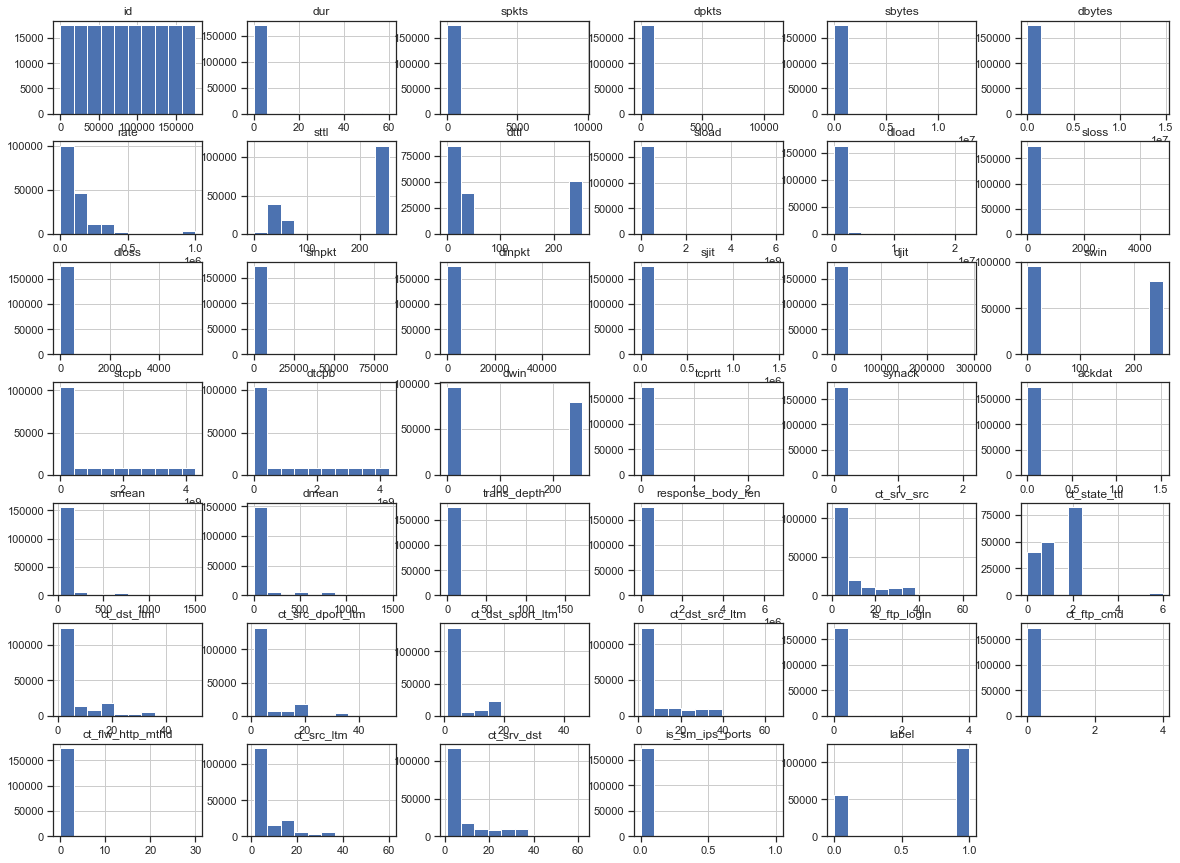

In [54]:
#%matplotlib inline # moved to top of notebook with imports
training_data.hist(figsize=(20,15))
plt.show()

### 3. Looking for Correlations and Visualizing

For training the ML models, we'll want to separate the class labels from the rest of the data.  But for investigating correlations, we'll want to include the labels.

### 4. ML prep

#### 4.1 Separate labels

Let's separate out the labels from the predicting features.  
*Should happen before handling categorical data and feature scaling.*

In [34]:
training = training_data.drop('label', axis=1) # what about attack_cat ?
training_labels = training_data['label'].copy()

In [38]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [41]:
training_labels

0         0
1         0
2         0
3         0
4         0
         ..
175336    1
175337    1
175338    1
175339    1
175340    1
Name: label, Length: 175341, dtype: int64

#### 4.2 Transform Categorical Features

Since these categorical features don't appear to have an inherent ordering, let's try encoding them as one-hot vectors for better ML performance.

In [8]:
training_data_onehot = pd.get_dummies(training_data, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
training_data_onehot.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,1,0.121478,6,4,258,172,74.087490,252,254,14158.942380,...,0,0,0,1,0,0,0,0,0,0
1,2,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,...,0,0,0,1,0,0,0,0,0,0
2,3,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,...,0,0,0,1,0,0,0,0,0,0
3,4,1.681642,12,12,628,770,13.677108,62,252,2740.178955,...,0,0,0,1,0,0,0,0,0,0
4,5,0.449454,10,6,534,268,33.373826,254,252,8561.499023,...,0,0,0,1,0,0,0,0,0,0


In [9]:
training_data_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Columns: 197 entries, id to state_no
dtypes: float64(11), int64(30), object(1), uint8(155)
memory usage: 82.1+ MB


OK, we still need to deal with the attack categories, but this doesn't look too bad.
We went from 45 columns to 197, that shouldn't be too unreasonable for ML.  We also still need to separate the classes/labels and we can probably drop the *id* feature, since it's just a sequential numbering of instances.

#### 4.3 Scale Features

Let's see the distribution of labels and classes.

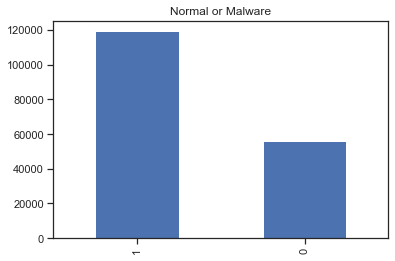

In [20]:
#_ = training_data['label'].value_counts().plot(kind='bar', title='Normal or Malware')
_ = training_data_onehot['label'].value_counts().plot(kind='bar', title='Normal or Malware')

In [21]:
#training_data['label'].value_counts()
training_data_onehot['label'].value_counts()

1    119341
0     56000
Name: label, dtype: int64

Here, 0 represents 'Normal' activity, and 1 is 'Malicious' activity (one of the 9 attack categories).

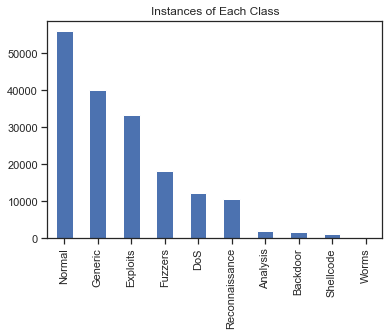

In [22]:
#_ = training_data['attack_cat'].value_counts().plot(kind='bar', title='Instances of Each Class')
_ = training_data_onehot['attack_cat'].value_counts().plot(kind='bar', title='Instances of Each Class')

In [23]:
#training_data['attack_cat'].value_counts()
training_data_onehot['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

Is there a danger of classification bias with this breakdown (only 130/175,341 instances are worms)?
What could we do to better balance without throwing away most of the data.
On the other hand this data set is probably representative of the percentages of malware in the wild.

We should calculate data correlations and plot a scatter matrix.

In [24]:
#correlation_matrix = training_data.corr()
correlation_matrix = training_data_onehot.corr()

And let's see how the features correlate to the label (normal or attack).  After converting the few categorical features to one-hot there are about 200 features to correlate.

In [25]:
correlation_matrix['label'].sort_values(ascending=False)

label           1.000000
id              0.727173
sttl            0.692741
ct_state_ttl    0.577704
state_INT       0.503995
                  ...   
swin           -0.333633
proto_tcp      -0.333726
dmean          -0.341806
state_CON      -0.366805
dload          -0.393739
Name: label, Length: 196, dtype: float64

Scatter matrix - let's check out a scatter matrix of some of these features to better vizualize the correlation

In [16]:
attrs = ['label', 'sttl', 'ct_state_ttl'] #, 'ct_dst_sport_ltm', 'rate', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'dwin', 'swin', 'dmean', 'dload']

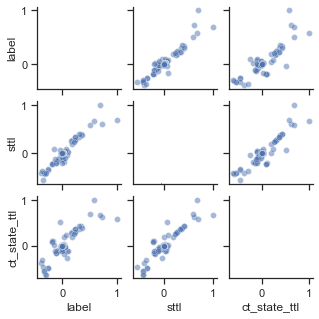

In [53]:
#training_data.plot.scatter()
#_ = scatter_matrix(correlation_matrix, figsize=(12,8))
#import seaborn as sns # added to import block at top of notebook
sns.set(style='ticks', color_codes=True)
_ = sns.pairplot(data=correlation_matrix[attrs], height=1.5, aspect=1, plot_kws={'alpha':0.5})

We can check out the statistics for each feature, do they need to be normalized?

In [26]:
# this isn't necessary because we can use describe on the DataFrame to see statistics of all numeric features
#feature_stats = pd.DataFrame()
#for feature in training_data.columns[1:-2]:
#    feature_stats = feature_stats.append(training_data[feature].describe())

In [27]:
#feature_stats

unique, top and freq are statistics of object type features, these will go away when those features are converted to numeric.

In [28]:
#feature_stats.info()

In [29]:
#feature_stats.shape

In [31]:
#training_data.describe().T
training_data_onehot.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
count,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,...,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,87671.000000,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,...,0.000319,0.075008,0.000068,0.443849,0.469229,0.000006,0.011355,0.000473,0.000006,0.000006
std,50616.731112,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,...,0.017868,0.263405,0.008272,0.496839,0.499054,0.002388,0.105954,0.021752,0.002388,0.002388
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43836.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,87671.000000,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,131506.000000,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,175341.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The *id* feature is just a sequential numbering of the records...it's probably not necessary.  If we drop that, convert the object/categorical types to numeric and excluded the categories and labels, this is an easier way to describe the data.

We'll probably want to scale these features using normalization or standardization.